#### **NEM Review contract co-design workshop**

# Contract financial performance modelling

## Prepare data

### Access generators from latest Generation Information

In [99]:
# Python libraries
import geopandas as gpd, matplotlib.pyplot as plt, matplotlib as mpl
import numpy as np,  os, pandas as pd, seaborn as sns, statsmodels.api as sm
from sqlalchemy import create_engine, text
from scripts.functions import python_setup, get_mms_data

# Set up Python
working_dir, charts_dir, data_dir = python_setup(2)
plt.style.use("dark_background")

# Get generator details
sa_gen_info = pd.read_csv(
    os.path.join(data_dir, "sa_duids.csv"),
    index_col=0)

# Count DUIDs used in analysis
for tech in sa_gen_info["Technology"].value_counts().index:
    print(f"{tech}: {sa_gen_info["Technology"].value_counts().loc[tech]} generators")

Wind: 26 generators
Solar: 19 generators


### Collect historic DUID data for South Australia

If no data yet exists, execute SQL query to collect output, availability and maximum capacity data for each DUID.

In [100]:
# SA DUID data path
sa_duid_data_path = os.path.join(data_dir, "sa_duid_data_largefile.csv")

# Check if file exists
if not os.path.exists(sa_duid_data_path):
    print("sa_duid_data_largefile.csv not found. Querying database ...")

    # Define DUIDs of interest
    duid_list = sa_gen_info.index

    # Get generation and price data
    sa_duid_data = get_mms_data(
        script_name="collect_sa_duid_data",
        arguments={
            "start_date": "2020-01-01",
            "end_date": "2024-12-31",
            "duid_list": ",".join([f"'{d}'" for d in duid_list])})

    # Save data to file
    sa_duid_data.to_csv(sa_duid_data_path, index=False)    
    print(f"Data saved successfully.")

else:
    print(f"Loading existing sa_duid_data_largefile.csv file ...")
    # Load existing data
    sa_duid_data = pd.read_csv(
        sa_duid_data_path,
        parse_dates=[0])

# Add name and technology
print("Joining with gen info data ...")
sa_duid_data["Technology"] = sa_duid_data["DUID"].map(lambda d: sa_gen_info.at[d, "Technology"])
sa_duid_data["Name"] = sa_duid_data["DUID"].map(lambda d: sa_gen_info.at[d, "Name"])

# Display market data
print("Data loaded successfully.")
sa_duid_data

Loading existing sa_duid_data_largefile.csv file ...
Joining with gen info data ...
Data loaded successfully.


,Interval,DUID,Output,Availability,Maximum capacity,Relative output,Relative availability,Technology,Name
0,2020-01-01 00:00:00,BLUFF1,0.0590,0.118,53.0,0.001113,0.002226,Wind,Hallett 5 The Bluff WF
1,2020-01-01 00:00:00,BNGSF1,0.0000,0.000,110.0,0.000000,0.000000,Solar,Bungala One Solar Farm
2,2020-01-01 00:00:00,BNGSF2,0.0000,0.000,110.0,0.000000,0.000000,Solar,Bungala Two Solar Farm
3,2020-01-01 00:00:00,CLEMGPWF,33.7193,33.294,57.0,0.591567,0.584105,Wind,Clements Gap Wind Farm
4,2020-01-01 00:00:00,HALLWF1,1.6255,1.351,95.0,0.017111,0.014221,Wind,Hallett Stage 1 Brown Hill
...,...,...,...,...,...,...,...,...,...
16953403,2024-12-31 23:55:00,TB2SF1,0.0000,0.000,87.0,0.000000,0.000000,Solar,Tailem Bend Stage 2 Solar Project
16953404,2024-12-31 23:55:00,TBSF1,0.0000,0.000,95.0,0.000000,0.000000,Solar,Tailem Bend - Solar
16953405,2024-12-31 23:55:00,WATERLWF,0.2500,0.000,130.0,0.001923,0.000000,Wind,Waterloo Wind Farm
16953406,2024-12-31 23:55:00,WGWF1,0.6000,0.700,119.0,0.005042,0.005882,Wind,Willogoleche Wind Farm


### Collect whole-of-market data for South Australia

If no data yet exists, execute SQL query to collect SA prices and total demand data.

In [101]:
# SA demand and prices path
sa_demand_and_prices_path = os.path.join(data_dir, "sa_demand_and_prices.csv")

# Check if file exists
if not os.path.exists(sa_demand_and_prices_path):
    print("sa_demand_and_prices.csv not found. Querying database ...")

    # Get generation and price data
    sa_demand_and_prices = get_mms_data(
        script_name="collect_sa_demand_and_prices",
        arguments={
            "start_date": "2020-01-01",
            "end_date": "2024-12-31"})
    sa_demand_and_prices.set_index("Interval", inplace=True)

    # Save data to file
    sa_demand_and_prices.to_csv(sa_demand_and_prices_path)
    print(f"Data saved successfully.")

else:
    print(f"Loading existing sa_demand_and_prices.csv file ...")
    # Load existing data
    sa_demand_and_prices = pd.read_csv(
        sa_demand_and_prices_path,
        parse_dates=[0],
        index_col=0)

# Display market data
print("Data loaded successfully.")
sa_demand_and_prices

Loading existing sa_demand_and_prices.csv file ...


Data loaded successfully.


,Total demand,Price
Interval,,
2020-01-01 00:00:00,1466.53,68.00000
2020-01-01 00:05:00,1422.33,68.00000
2020-01-01 00:10:00,1425.70,68.50000
2020-01-01 00:15:00,1423.95,68.50000
2020-01-01 00:20:00,1389.36,68.50000
...,...,...
2024-12-31 23:35:00,1375.14,130.16134
2024-12-31 23:40:00,1369.37,141.79538
2024-12-31 23:45:00,1372.97,130.58007


## Observations of SA wind and solar market

Calculate and visualise metrics of:
* Size of the wind and solar fleets over time (2020 to 2024)
* Locations of generators
* Capacity factors of generators
* Intraday shape of wind generation, solar generation and load
* Demand-weighted prices for SA (whole of market), wind and solar

### Size of wind and solar fleets

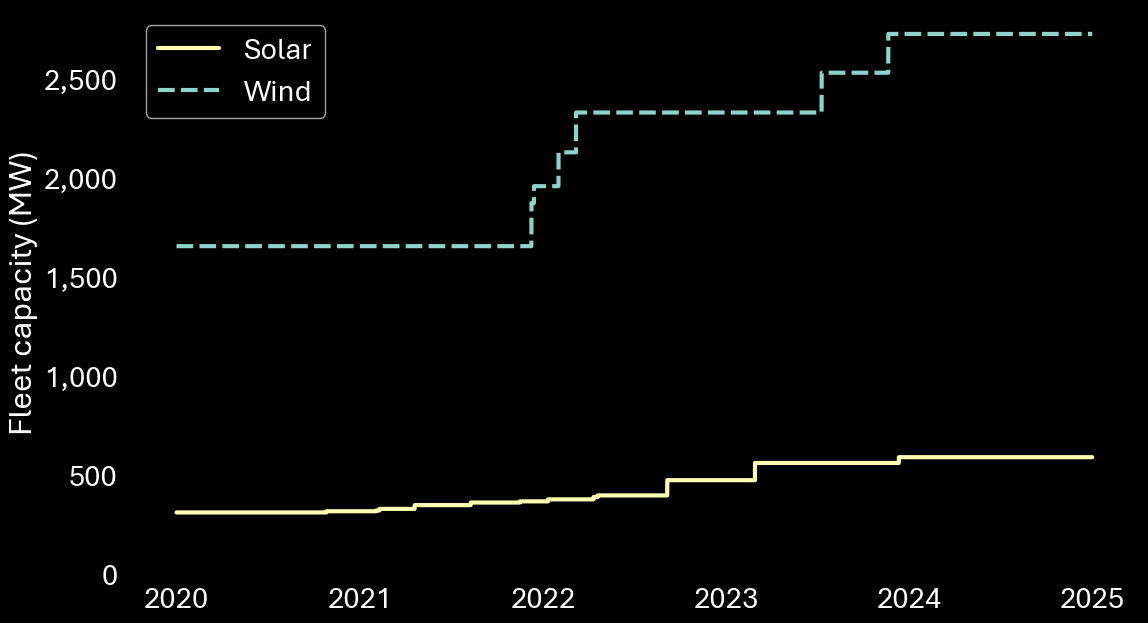

In [102]:
# Identify changes in DUID maximum capacity
for duid in sa_gen_info.index:
    name = sa_gen_info.at[duid, "Name"]
    duid_data = sa_duid_data[sa_duid_data["DUID"] == duid]
    capacity_readings = len(duid_data["Maximum capacity"].unique())
    if capacity_readings > 1:
        print(f"{duid} ({name}) has {capacity_readings} values of maximum capacity.")
    if capacity_readings > 0:
        sa_gen_info.at[duid, "Maximum capacity"] = duid_data.iloc[-1]["Maximum capacity"]

# Plot fleet sizes over time
fig, ax = plt.subplots(
    figsize=(12, 6.75),
    tight_layout=True)

chart_data = sa_duid_data.pivot_table(
    index="Interval",
    columns="Technology",
    values="Maximum capacity",
    aggfunc="sum")
sns.lineplot(
    data=chart_data,
    palette=["C1", "C0"],
    linewidth=3)
plt.xlabel(None)
plt.ylabel("Fleet capacity (MW)")
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
plt.ylim(0)
plt.legend(title=None)
for frame in ["top", "right", "bottom", "left"]:
    ax.spines[frame].set_visible(False)
plt.savefig(
    os.path.join(charts_dir, "growth_of_sa_fleet.png"))
plt.show()

### Locations of generators


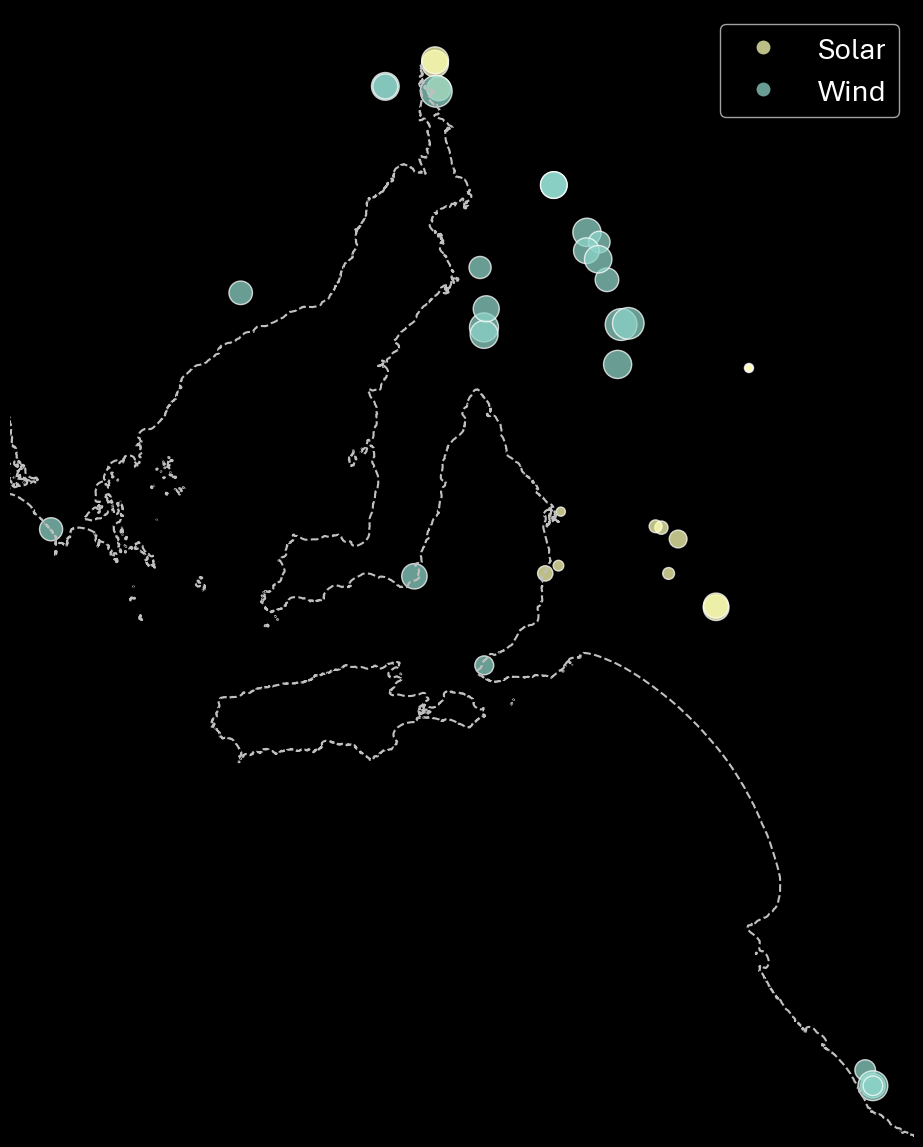

In [117]:
# Convert DUIDs to GeoDataFrame
sa_gen_geo = gpd.GeoDataFrame(
    sa_gen_info,
    geometry=gpd.points_from_xy(
        sa_gen_info.Longitude,
        sa_gen_info.Latitude,
        crs="3857"))

# Load states shapefile
states = gpd.read_file(
    os.path.join(data_dir, "states.zip"))

# Plot states outline
marker_sizes = np.sqrt(sa_gen_geo["Maximum capacity"] / np.pi)
fig, ax = plt.subplots(
    figsize=(12, 12),
    tight_layout=True)
sa_gen_geo.plot(
    "Technology",
    cmap=mpl.colors.ListedColormap(["C1", "C0"]),
    markersize=(
        (np.sqrt(sa_gen_geo["Maximum capacity"] / np.pi) - marker_sizes.min()) / 
        (marker_sizes.max() - marker_sizes.min()) * 500 + 25),
    alpha=.75,
    edgecolor="white",
    ax=ax,
    legend=True)
limits = ax.get_xlim(), ax.get_ylim()
states.boundary.plot(
    color="silver",
    linestyle="--",
    ax=ax)
plt.xlim(limits[0][0], limits[0][1])
plt.ylim(limits[1][0], limits[1][1])
ax.set_axis_off()
plt.savefig(
    os.path.join(charts_dir, "sa_generator_locations.png"))
plt.show()

### Capacity factors of generators

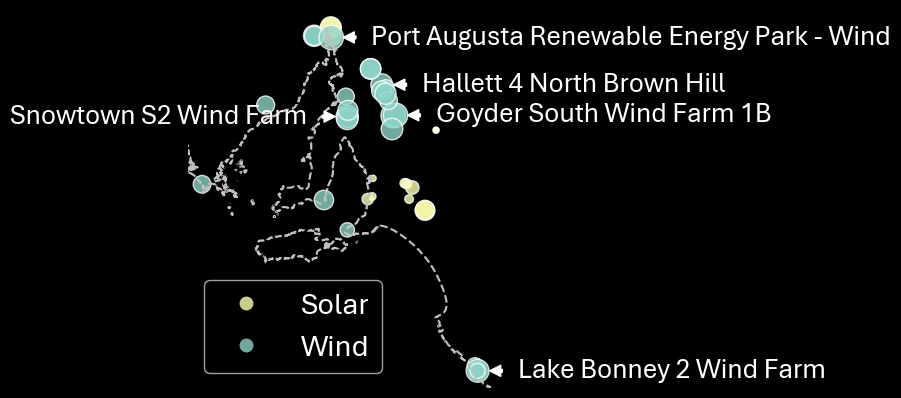

In [104]:
sa_duid_data.pivot_table(
    index="DUID",
    columns="Technology",
    values="Relative output",
    aggfunc="mean")

# Plot states outline
fig, ax = plt.subplots(
    figsize=(9, 6.75),
    tight_layout=True)
sa_gen_geo.plot(
    "Technology",
    cmap=mpl.colors.ListedColormap(["C1", "C0"]),
    markersize=(
        (np.sqrt(sa_gen_geo["Maximum capacity"] / np.pi) - marker_sizes.min()) / 
        (marker_sizes.max() - marker_sizes.min()) * 300 + 10),
    alpha=.8,
    edgecolor="white",
    ax=ax,
    legend=True)
label_data = sa_gen_geo.loc[["NBHWF1", "SNOWNTH1", "LKBONNY2", "GSWF1B1", "PAREPW1"]].copy()
for x, y, label in zip(
    label_data["geometry"].x,
    label_data["geometry"].y,
    label_data["Name"]):
    ax.annotate(
        label,
        xy=(x, y),
        xytext=(x + (.7 if "Snowtown" not in label else - .7), y),
        fontsize="small",
        ha=("left" if "Snowtown" not in label else "right"),
        va="center",
        arrowprops=dict(
            color="white",
            width=2,
            headwidth=8,
            headlength=8,
            shrink=0.3))
limits = ax.get_xlim(), ax.get_ylim()
states.boundary.plot(
    color="silver",
    linestyle="--",
    ax=ax)
plt.xlim(limits[0][0], limits[0][1])
plt.ylim(limits[1][0], limits[1][1])
ax.set_axis_off()
plt.savefig(
    os.path.join(charts_dir, "sa_generator_locations.png"))
plt.show()

In [105]:
sa_duid_data.pivot_table(
    index="DUID",
    columns="Relative output",
    aggfunc="mean"
)

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
# Prepare for demand waiting
sa_demand_and_prices["Total value"] = sa_demand_and_prices.iloc[:, :2].product(axis=1)

# Quarterly DWA prices
sa_demand_and_prices_qtr = sa_demand_and_prices.resample("QE").sum()
sa_demand_and_prices_qtr["DWA price"] = sa_demand_and_prices_qtr["Total value"] / sa_demand_and_prices_qtr["Total demand"]

sa_demand_and_prices

,Total demand,Price,Total value,DWA price
Interval,,,,
2020-01-01 00:00:00,1466.53,68.00000,99724.040000,68.00000
2020-01-01 00:05:00,1422.33,68.00000,96718.440000,68.00000
2020-01-01 00:10:00,1425.70,68.50000,97660.450000,68.50000
2020-01-01 00:15:00,1423.95,68.50000,97540.575000,68.50000
2020-01-01 00:20:00,1389.36,68.50000,95171.160000,68.50000
...,...,...,...,...
2024-12-31 23:35:00,1375.14,130.16134,178990.065088,130.16134
2024-12-31 23:40:00,1369.37,141.79538,194170.339511,141.79538
2024-12-31 23:45:00,1372.97,130.58007,179282.518708,130.58007
